# Anaerobic Threshold via $ \dot{V}O_2max $ and $ v_{La} max $ 
In this simulation we show how to calculate the anaerobic threshold (**AT**) based on the maximal oxygen uptake ($ \dot{V}O_2max $) and the maximal lactate formation rate ($ v_{La}max $). All calculations are based on the physiological model outlined in **Mader & Heck (1986) "A Theory of the Metabolic Origin of 'Anaerobic Treshold'"**. 

In the first step we import the necessary libraries into our program.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as sha
from pylab import rcParams

# change size of all figures in this notebook
rcParams['figure.figsize'] = 18, 8

## Model Input
Before we dive into the calculations we need to define a couple of parameters to inform our model. We give some reasoning for these values while explaining the physiological model in the next paragraph. First, there are some independent variables that can be measured beforehand in order to calculate **AT**:

- $ \dot{V}O_2max $ : The maximal oxygen uptake relative to body weight in $ \frac{ml}{kg_{bw} \cdot min} $
- $ v_{La} max $ : The maximum rate of glycolysis expressed as lactic acid formation in $ \frac{mmol}{s} $
- **Running Economy** expressed in $ \frac{ml}{kg_{bw} \cdot min \cdot m \cdot s}$

Next, we simulate theoretical oxygen demands:

- $ \dot{V}O_2ss $ describes the steady state oxygen demands in $ \frac{ml}{kg \cdot min}$ and is generated by a sequential array within the boundary of $ \dot{V}O_2max $

Further, constant values are defined:

- $ K_{s1} $ : Constant in the activation formula for *ADP* on $ \dot{V}O_2 ss$. Assumed to be $ (0.25 \frac{mmol}{kg_{muscle}})^2 $ - range: 0.2-0.3
- $ K_{s2} $ : Constant in the activation formula for *ADP* on $ v_{La} ss $ (glycolysis due mainly to Phosphofructokinase (PFK)-activation). Assumed to be $ (1.2 \frac{mmol}{kg_{muscle}})^3 $ - range: 1.0 - 1.3
- **VolRel** : relative distribution space of lactate per $ kg_{bw} $


In [24]:
# Input based on diagnostic
VO2max = 58.6       # ml/kg/min
vLamax = 0.5        # mmol/l/s
RunningEco = 11.95  # ml/kg/min/m/s

# Generate oxygen steady-states
VO2ss = np.arange(1, VO2max-5, 0.01) # substract 5 for better visualisation

# Define constants
Ks1 = 0.25 ** 2     # Range: 0.2 - 0.3
Ks2 = 1.2 ** 3      # Range: 1.0 - 1.3
VolRel = 0.45       # Range: 0.40 - 0.45, depends on individual body composition

## The Physiological Model
### Activation of oxidative phosphorylation by ADP
During exercise *ATP* is converted to *ADP* (and *AMP*) to yield energy. In this model the activation of glycolysis occurs in an allosteric relation to *ADP* and *AMP*. It is stated, that *AMP* is proportional to *ADP²*. Therefore, *ADP* x *AMP* is equivalent to the third power of *ADP*. *ADP* and *AMP* must be multiplied (instead of added), because the activation due to *AMP* is amplified. Consequently, the activation of glycolysis can be calculated from *ADP*. The authors approximate that the activation of the respiratory chain and glycolysis can be expressed in the same way. The following equation may be used to calculate *ADP*  in $ \frac{mmol}{kg_{muscle}} $ (see eq. 4b in the paper):

$$ ADP = \sqrt{\frac{K_{s1} \cdot \dot{V}O_2ss}{\dot{V}O_2max - \dot{V}O_2ss}} $$

In [25]:
# calculate ADP corresponding to VO2ss (eq. 4b)
ADP = np.sqrt((Ks1 * VO2ss) / (VO2max - VO2ss)) 

The included constant $ K_{s1} $ is based on experimental observations to be in the range of 0.2 to 0.3 $ \frac{mmol}{kg_{muscle}} $. $ K_{s1} $'s exponent is supposed to be 1, if Michaelis-Menten kinetic* is assumed. Unfortunately this exponent does not allow  $ \dot{V}O_2 $ as a function of the *ADP* concentration in a physiologically possible range. To meet the assumption of an allosteric reaction an exponent of 2 is suggested. 

    *Michaelis-Menten Kinetic: Describes the activity of an enzyme as a function of the substrate concentration.

### Activation of glycolysis by PFK / ADP
Under the assumption that the activation of PFK is sigmoidally related to $ ADP \cdot AMP  \hat{=}  ADP^3 $, formation of lactic acid $ \frac{\Delta La}{\Delta t}ss = v_{La}ss $ in $ \frac{mmol}{s \cdot l} $ can be calculated using the following formula (see eq. 3):

$$ v_{La}ss = \frac{v_{La} max}{1+ \frac{K_{s2}}{ADP^3}} $$

In [26]:
# calculate steady state gross lactic acid (pyruvate) formation rate (eq. 3)
vLass = 60 * vLamax / (1 + ( Ks2 / ADP ** 3))

$ K_{s2} $ is the 50% rate constant of glycolysis due mainly to PFK activation. It is supposed to be in the range of (1.0- 1.3 $ \frac{mmol}{kg_{muscle}} $
muscle to the power of three. 
Now we have calculated the production of pyruvate (or lactate) by glycolysis for a given $ \dot{V}O_2ss $, assuming that $ \dot{V}O_2max $ and $ v_{La}max $  are known. Note that $ v_{La}max $ is multiplied by 60 in our code to convert seconds into minutes. Let's visualize this!

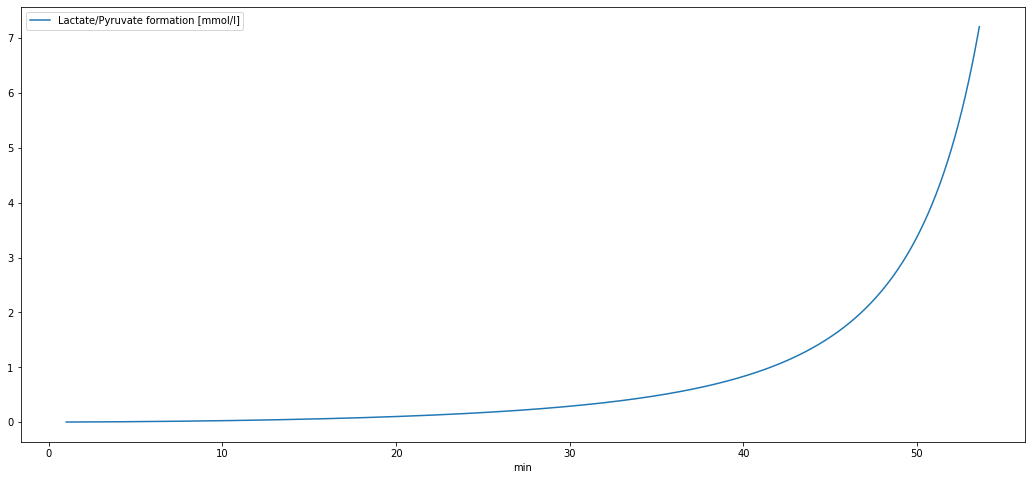

In [27]:
# plot gross lactate formation
plt.plot(VO2ss, vLass)
plt.xlabel("min")
plt.legend(['Lactate/Pyruvate formation [mmol/l]'])

### Lactate formation and combustion
As produced pyruvate (or lactate) can be combusted, the net formation rate of lactate (eg, what is measured) is the difference between produced and combusted lactate. In order to relate to the combustion of lactate, we must assess the influence of the energy charge of lactic acid formation and combustion and the distribution to the body's water compartment. 

First, we need to establish the *energy equivalent* of 1 mmol lactate. The free energy of glucose is **~2874 $ \frac{kJ}{mol} $**, with a maximum net gain of 38 mol ATP through glycolysis and the citric-acid-cycle. The breakdown of 1 mol glucose to 2 mol lactate (or pyruvate + NADH + H+) yields **~197 kJ** and **2 mol ATP**. 
Consequently, we obtain $ \frac{2874 - 197}{2} = 1338.5 \frac{kJ}{mol} $ lactate, with a maximum net gain of **18 mol ATP per mol lactate**. 

We assume a net gain of either 17 or 18 mol ATP per mol of lactate. Following, 1 mmol ATP lactate yields between $ \frac{1338.5}{17} \approx 78.74 kJ $ and $ \frac{1338.5}{18} \approx 74.36 kJ $, respectively, which is in accordance to reported values. 

If we assume a P/O quotient (ATP per Oxygen) of 3, the following holds true: 

- Net gain of 18 mol ATP per mol lactate -> 1 mmol lactate requires 67.2 ml oxygen, or 1 ml oxygen oxidizes 0.014881 mmol lactate or pyruvate. 

- Net gain of **17 mol ATP** per mol lactate -> 1 mmol lactate requires 70.8 ml oxygen, or 1 ml oxygen oxidizes **0.01576 mmol lactate** or pyruvate. 

We must keep in mind, that the change of the lactate distribution in tissue blood depends on the distribution volume in reference to the total space. The available distribution space of lactate is supposedly *45%* (*VolRel*) of the entire body mass. Therefore:

$ \frac{0.01576}{0.45} = 0.035 \frac{mmol}{l} $ per $ \frac{O_2[ml]}{kg_{bw}} $ -> 0.035 mmol/l lactate is combusted per ml oxygen per kilogram body weight. 

Following this rationale, we are now able to calculate the maximum number of lactate that can be combusted for a given $ \dot{V}O_2ss $ (see eq. 6):


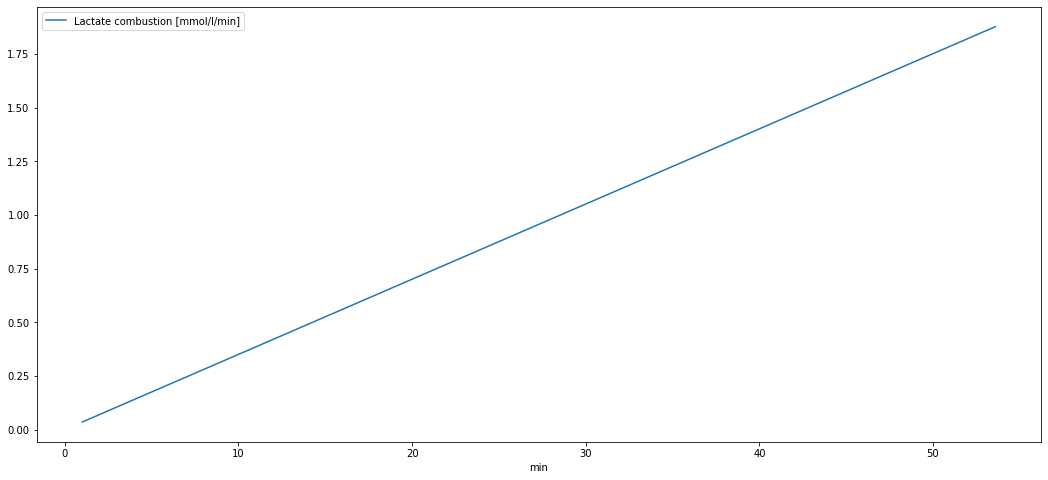

In [28]:
# calculate lactate combustion (eq. 6)
LaComb = (0.01576/VolRel) * VO2ss

# plot lactate combustion
plt.plot(VO2ss, LaComb)
plt.xlabel("min")
plt.legend(['Lactate combustion [mmol/l/min]'])

### The crossing point: "Anaerobic Threshold"
As we have indicated earlier, the actual net lactate formation can now be calculated as the difference between lactate formation and combustion (see eq. 6 and 7). Now we plot all simulated values together. The crossing point between the gross lactate formation and potential lactate removal indicates the **AT**. Net lactate production at this point is equal to zero. Below the crossing point `vLanet` describes the lack of pyruvate. This displays the possible use of fatty acids as pyruvate equivalents. Therefore, the maximum lack of pyruvate represents the point of maximal fuel supply by fatty acids.
Above the crossing `vLanet` describes lactate production in $ \frac{mmol}{l \cdot min} $. 

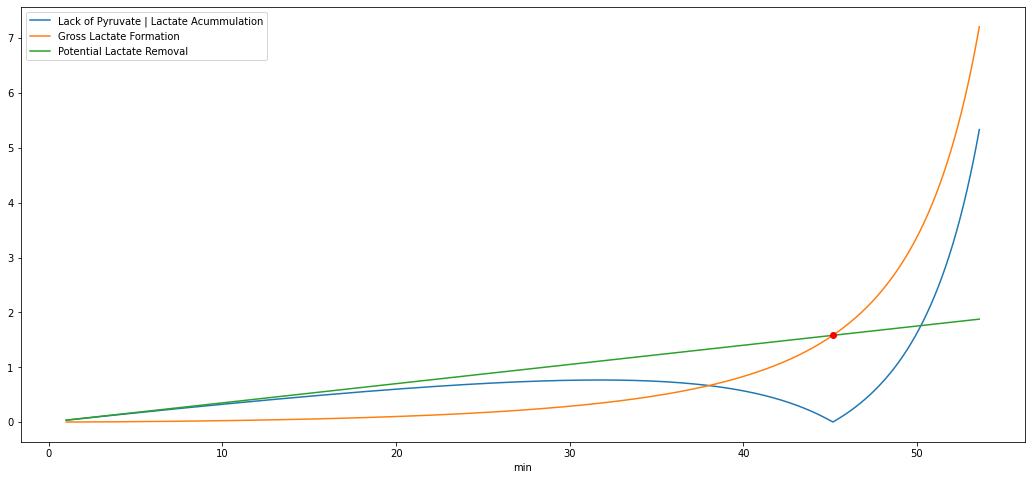

In [29]:
# calculate net lactate formation
vLanet = abs(vLass - LaComb)

# plot all lactate curves
plt.plot(VO2ss, vLanet)
plt.plot(VO2ss, vLass)
plt.plot(VO2ss, LaComb)

plt.xlabel("min")
plt.legend(['Lack of Pyruvate | Lactate Acummulation', 
            'Gross Lactate Formation', 
            'Potential Lactate Removal'])

# calculate the crossing point (AT) between gross lactate production and combustion
line1 = sha.LineString(np.column_stack((vLass, VO2ss)))
line2 = sha.LineString(np.column_stack((LaComb, VO2ss)))
VO2AT = line1.intersection(line2)

# highlight the crossing point in red
plt.plot(VO2AT.y,VO2AT.x, 'ro')

For this visualisation we are assuming a running economy of $ 12.5 \frac{ml}{kg \cdot min \cdot m \cdot s} $ . We can now calculate the speed at **AT** and the fractional utilization of $ \dot{V}O_2max $.

In [30]:
# speed at anaerobic threshold
sAT = VO2AT.y / RunningEco 

# percentage of VO2max
pcVO2maxAT = VO2AT.y / VO2max

print(f'AT is at {round(sAT,2)} m/s, {round(pcVO2maxAT*100,1)}% of VO2max')

AT is at 3.78 m/s, 77.1% of VO2max


## Interactive Visualisation
In the following we have summarized our code into a single function. In order to call the function, $ \dot{V}O_2max $, $ v_{La}max $, *running economy*, $ K_{s1} $, $ K_{s2} $ and *VolRel* must be passed into the function. Note, that we have changed the x-axis to be expressed in $ \frac{m}{s} $. 

In [31]:
def plotLactate(VO2max, vLamax, RunningEco, Ks1, Ks2, VolRel):
    
    # generate oxygen steady-states
    VO2ss = np.arange(1,VO2max,0.01)
    
    # potentiate constants
    Ks1 = Ks1 ** 2
    Ks2 = Ks2 ** 3
    
    # calculate ADP corresponding to VO2ss (eq. 4b)
    ADP = np.sqrt((Ks1 * VO2ss) / (VO2max - VO2ss)) 
    
    # calculate steady state gross lactic acid (pyruvate) formation rate (eq. 3)
    vLass = 60 * vLamax / (1 + ( Ks2 / ADP ** 3))

    # calculate lactate combustion (eq. 6)
    LaComb = (0.01576/VolRel) * VO2ss

    # calculate net lactate formation
    vLanet = abs(vLass - LaComb)
        
    # calculate the crossing point (AT) between gross lactate production and combustion
    line1 = sha.LineString(np.column_stack((vLass, VO2ss)))
    line2 = sha.LineString(np.column_stack((LaComb, VO2ss)))
    VO2AT = line1.intersection(line2)

    # speed at anaerobic threshold
    sAT = VO2AT.y / RunningEco 

    # percentage of VO2max
    pcVO2maxAT = VO2AT.y / VO2max
    
    # print to console
    print(f'AT is at {round(sAT,2)} m/s, {round(pcVO2maxAT*100,1)}% of VO2max')
        
    # convert VO2ss into velocity (m/s)
    v = VO2ss / RunningEco
    
    # plot all lactate curves
    plt.plot(v, vLanet)
    plt.plot(v, vLass)
    plt.plot(v, LaComb)
    
    plt.xlabel("m/s")
    plt.legend(['Lack of Pyruvate | Lactate Acummulation', 
                'Gross Lactate Formation', 
                'Potential Lactate Removal'])
    
    # set limits for interactive visualisation
    plt.ylim( 0, 8 )
    plt.xlim( 0, 6 )
        
    # vertical line at AT
    
    plt.axvline(x=sAT)

AT is at 3.78 m/s, 77.1% of VO2max


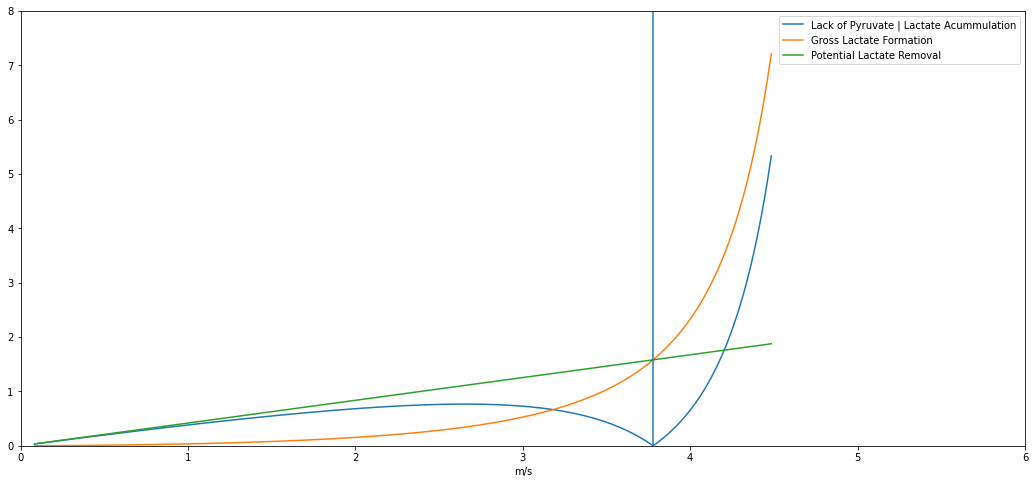

In [32]:
plotLactate(
    VO2max = 58.6,       
    vLamax = 0.5,      
    RunningEco = 11.95,
    Ks1 = 0.25,     
    Ks2 = 1.2,    
    VolRel = 0.45)

Using the following tool you may manipulate the different parameters of the equation in isolation to get a grasp of each parameters influence on the metabolic profile.

In [33]:
import ipywidgets as widgets

widgets.interact(plotLactate, 
         VO2max = widgets.FloatSlider(value=55, min=40, max=80,step=0.5),
         vLamax = widgets.FloatSlider(value=0.5, min=0.2, max=1.5,step=0.01),
         RunningEco = widgets.FloatSlider(value=11.95, min=10, max=15,step=0.05),
         Ks1 = widgets.FloatSlider(value=0.25 , min=0.2, max=0.3,step=0.01),
         Ks2 = widgets.FloatSlider(value=1.2, min=1, max=1.3,step=0.01),
         VolRel = widgets.FloatSlider(value=.45, min=.42, max=.45,step=0.01))

interactive(children=(FloatSlider(value=55.0, description='VO2max', max=80.0, min=40.0, step=0.5), FloatSlider…

<function __main__.plotLactate(VO2max, vLamax, RunningEco, Ks1, Ks2, VolRel)>

## Literature
Mader, A., & Heck, H. (1986). A Theory of the Metabolic Origin of “Anaerobic Threshold”. International Journal of Sports Medicine, 07(S 1), S45-S65. https://doi.org/10.1055/s-2008-1025802
